In [59]:
import pandas as pd
import numpy as np
import statistics 

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('ggplot')
%matplotlib inline

# Case 1

In [68]:
df1 = pd.read_csv('TFP.csv')
df1.year = pd.to_datetime(df1.year,format = '%Y', errors='raise')

In [109]:
country_grouped = df1.groupby('isocode')
df1.head()

,isocode,year,rtfpna
0,USA,1950-01-01,0.617148
1,USA,1951-01-01,0.629588
2,USA,1952-01-01,0.638451
3,USA,1953-01-01,0.651858
4,USA,1954-01-01,0.646179


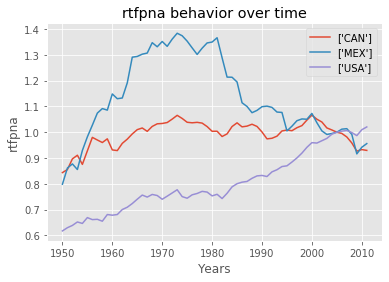

In [157]:
fig, ax = plt.subplots()
country_grouped.apply(lambda x: ax.plot(x.year,x.rtfpna, label = x['isocode'].unique()))
plt.title('rtfpna behavior over time')
plt.xlabel('Years')
plt.ylabel('rtfpna')
ax.legend()

TFP = Total factor productivity

'produtividade total dos fatores a preços nacionais constantes'

It is possible to see that the USA maintained steady growth throughout the historical series, while Mexico saw a fall that almost equaled the level of 1950.

Canada advanced laterally over the years with a steady result between 0.9 and 1.

In [143]:
diff = country_grouped.apply(lambda x: x.rtfpna - x.rtfpna.shift(-1))

In [158]:
diff

isocode    
CAN      62   -0.011788
         63   -0.041366
         64   -0.014169
         65    0.035480
         66   -0.052504
                 ...   
USA      57    0.008096
         58    0.011761
         59   -0.022725
         60   -0.010929
         61         NaN
Name: rtfpna, Length: 186, dtype: float64

In [127]:
#a = df1[df1['isocode'] == 'USA']
#a= a.drop(['isocode'],axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F97803A848>]],
      dtype=object)

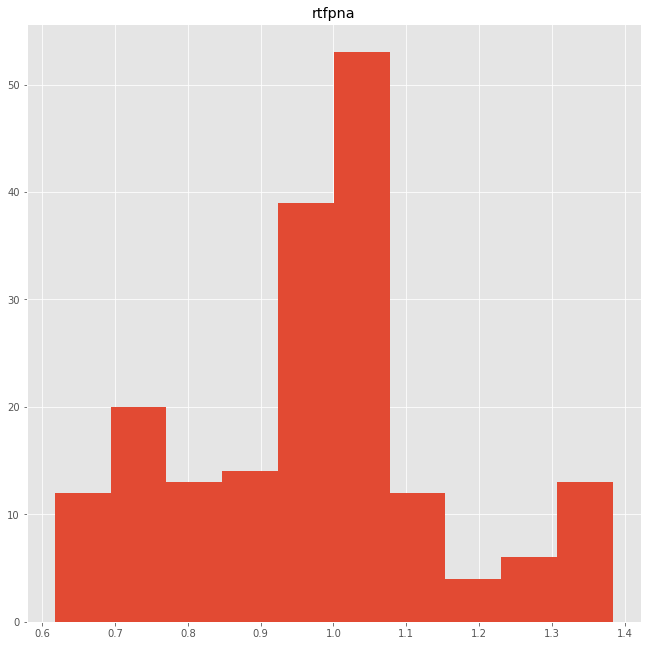

In [129]:
df1[df1.dtypes[(df1.dtypes=="float64")|(df1.dtypes=="int64")].index.values].hist(figsize=[11,11])

# Case 2

# Objetivos

1 - Apresentar a evolução mensal e anual das exportações (de todos os estados e para todos os lugares) de ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

2 - Quais são os 3 produtos mais importantes exportados pelo Brazil nos últimos 5 anos?

3 - Qual a principal rota de exportação do milho do brasil nos ultimos anos? A rota tem relação expressiva dependendo do produto?

4 - Quais países são os maiores parceiros em milho e açucar dos últimos 3 anos?

5 - Mostrar para cada produto do dataset quais os cinco estados mais importantes para exportação.

6 - Baseado nos dados do covariantes, qual a estimativa de total de exportação de soybean_meal, e corn do Brasil dos próximos 11 anos? (2020-2030).

# Case 2

# Pre processing data

In [3]:
df = pd.read_csv('data_comexstat.csv', sep=',', encoding = "ISO-8859-1")

In [4]:
MILLION = 1000000

In [5]:
df.date = pd.to_datetime(df.date,yearfirst = True, errors='raise')

In [6]:
#create dataframe indexed by date
date_grouped = df.set_index('date')
#date_grouped['year'] = date_grouped.index.year
#date_grouped['month'] = date_grouped.index.month
#date_grouped['year_month'] = date_grouped['year'].astype(str) + date_grouped['month'].astype(str)
#date_grouped['day'] = date_grouped.index.day

# 1 - Evoluation of exports

As exportações apresentaram um aumento com o passar dos anos, e pela distribuição no gráfico é possível observar uma sasonalidade na produção (alguns messes apresentam uma grande queda nas exportações).

E ainda possível identificar que se trata de uma distribuição não estacionária com tendência de crescimento.

In [7]:
#Validation product types and exportacion or importation
item_1 = (((date_grouped['product'] == 'soybeans') | (date_grouped['product'] == 'soybean_oil') | (date_grouped['product'] == 'soybean_meal')) & (date_grouped['type'] == 'Export'))
sampled_item_1 = date_grouped.apply(lambda x: x[item_1])

In [8]:
#a = sampled_item_1.groupby(sampled_item_1.year_month).apply(lambda x: x.tons)


In [9]:
sampled_item_1

,product,state,country,type,route,tons,usd
date,,,,,,,
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,419.070,119318.0
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,5000.000,1414250.0
1997-01-01,soybean_meal,MS,Germany,Export,Sea,140.672,38378.0
1997-01-01,soybean_meal,MS,Hungary,Export,Sea,15000.000,4042100.0
1997-01-01,soybean_meal,MS,Netherlands,Export,Sea,14000.000,3850162.0
...,...,...,...,...,...,...,...
2019-12-01,soybeans,SP,Liberia,Export,Other,0.004,11.0
2019-12-01,soybeans,SP,Liberia,Export,Other,0.006,30.0
2019-12-01,soybeans,SP,Thailand,Export,Sea,146.499,52813.0


In [10]:
#date_grouped[date_grouped['product'] == 'soybean_meal']

In [11]:
#Sum of exportancion by month
exportacion = sampled_item_1['tons'].sum(level='date')/MILLION
months = sampled_item_1.index.unique()

C:\Users\stiva\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Tonnes (millions)')

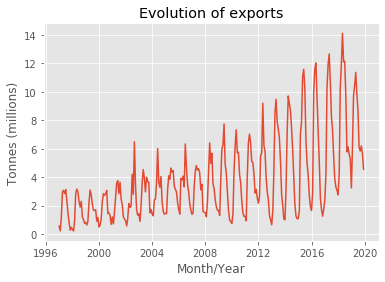

In [12]:
#Plot
fig, ax = plt.subplots()
plt.plot(months, exportacion)
plt.title('Evolution of exports')
plt.xlabel('Month/Year')
plt.ylabel('Tonnes (millions)')

# 2 - Most importante products

Produto mais exportado:

Produto com maior retorno em dolares:

In [13]:
item_2 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [14]:
sampled_item_2 = date_grouped.apply(lambda x: x[item_2])

In [15]:
total = sampled_item_2.set_index('product')
values_to_plot = total['tons'].sum(level='product')/1000
products_by_usd = total['usd'].sum(level='product')/MILLION

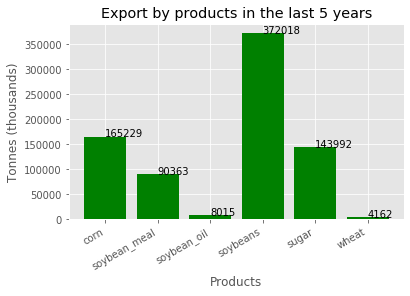

In [16]:
#Plot

products = sampled_item_2['product'].unique()

fig, ax = plt.subplots()
plt.bar(products, values_to_plot, color = 'green' )
fig.autofmt_xdate()
plt.title('Export by products in the last 5 years')
plt.xlabel('Products')
plt.ylabel('Tonnes (thousands)')

for i in range(len(products)):
    plt.text(x = products[i],y = values_to_plot[i], s = int(values_to_plot[i]) )


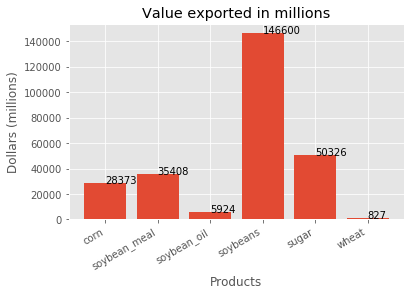

In [17]:
products = sampled_item_2['product'].unique()

fig, ax = plt.subplots()
plt.bar(products, products_by_usd)
fig.autofmt_xdate()
plt.title('Value exported in millions')
plt.xlabel('Products')
plt.ylabel('Dollars (millions)')

for i in range(len(products)):
    plt.text(x = products[i],y = products_by_usd[i], s = int(products_by_usd[i]) )

# 3 - Routes of corn exportation 

The most importante route is Sea representing 95.6% of total corn exports in last 5 years.

Sea exports represent the largest export channel for all types of products

In [18]:
#Get last 5 years, exports and corn
item_3 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export') & (date_grouped['product'] == 'corn'))
item_3_1 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [19]:
sampled_item_3 = date_grouped.apply(lambda x: x[item_3])
sampled_item_3_1 = date_grouped.apply(lambda x: x[item_3_1])

In [20]:
routes_corn_export = sampled_item_3.groupby('route').apply(lambda x: x.tons.sum()/1000)

In [21]:
#Sea representation export 
routes_corn_export['Sea']/routes_corn_export.sum()*100

95.6621529645743

In [22]:
#Function do calcule the tonnes exported by product
def route_importance(df_product):
    return df_product.groupby('route').apply(lambda x: x.tons.sum()/1000)

route_export = sampled_item_3_1.groupby('product').apply(route_importance)

In [23]:
#Show the values os each route of export by product
pd.DataFrame(route_export, columns=['tonnes'])

tonnes
product      route                
corn         Air         10.269443
             Ground      84.742677
             Other      268.070581
             River     6804.322840
             Sea     158062.153788
soybean_meal Air         22.025387
             Ground       8.625618
             Other       91.497169
             River        0.197400
             Sea      90241.465265
soybean_oil  Air          0.002977
             Ground     147.568310
             Other       30.132451
             River        4.172127
             Sea       7833.152083
soybeans     Air          0.060873
             Ground     102.726098
             Other     1519.020844
             River     9444.940451
             Sea     360951.896367
sugar        Air          0.033086
             Ground     742.326864
             Other       51.614345
             River       46.786306
             Sea     143151.635013
wheat        Air          0.001299
             Ground      39.585222
             Other        0.013718
             Sea       4123.251726

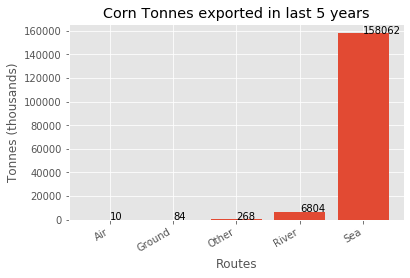

In [24]:
routes = sampled_item_3['route'].unique()
routes = np.sort(routes)

fig, ax = plt.subplots()
plt.bar(routes, routes_corn_export)
fig.autofmt_xdate()
plt.title('Corn Tonnes exported in last 5 years')
plt.xlabel('Routes')
plt.ylabel('Tonnes (thousands)')

for i in range(len(routes)):
    plt.text(x = routes[i], y = routes_corn_export[i], s = int(routes_corn_export[i]) )

# 4 - Most important partens with corn and sugar

173 countries are realized importation or exportation with Brazil considering sugar or corn after 2016 (3 yeas ago), was analised the top 10 countries using total of tonnes exported and total usd (dollars) movimented.

It was possible to identify that Iran was the principal destiny of exportation of theses products (23.3 millions of tonnes), and bigest font of usd (4.3 billions).
The second most import country was Egypt considering total of tonnes, but in relation with dollars payed to Brazil is the 4°.

Considering the importation the values are much smaller, the bigest value in tonnes is with Paraguay (4.3 millions of tonnes), and 602 millions of dollars.

In [25]:
#relationship_between_countries
rbc = pd.DataFrame()

In [26]:
item_4 = (((date_grouped['product'] == 'corn') | (date_grouped['product'] == 'sugar')) & (date_grouped.index.year >= 2016))

In [27]:
sampled_item_4 = date_grouped.apply(lambda x: x[item_4])

In [28]:
#Function to calcule the total of tonnes imported and exported per each country
def total_negotiation_export(df_country):
    export_total = df_country[df_country['type'] == 'Export']['tons'].sum()/MILLION
    return export_total

def total_negotiation_import(df_country):
    import_total = df_country[df_country['type'] == 'Import']['tons'].sum()/MILLION
    return import_total

In [29]:
#Function to calcule the total of USD (dollars) imported and exported per each country
def total_usd_export(df_country):
    export_total_usd = df_country[df_country['type'] == 'Export']['usd'].sum()/1000000000
    return export_total_usd

def total_usd_import(df_country):
    import_total_usd = df_country[df_country['type'] == 'Import']['usd'].sum()/MILLION
    return import_total_usd

In [30]:
#Apply the functions to sum
rbc['export_total'] = sampled_item_4.groupby('country').apply(total_negotiation_export)
rbc['import_total'] = sampled_item_4.groupby('country').apply(total_negotiation_import)

rbc['export_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_export)
rbc['import_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_import)

In [31]:
#Get the top 5 countries in import and export by tonnes and usd
top_tons_export = rbc.sort_values('export_total',ascending=False).head(10)
top_tons_import = rbc.sort_values('import_total',ascending=False).head(10)

top_usd_export = rbc.sort_values('export_total_usd',ascending=False).head(10)
top_usd_import = rbc.sort_values('import_total_usd',ascending=False).head(10)

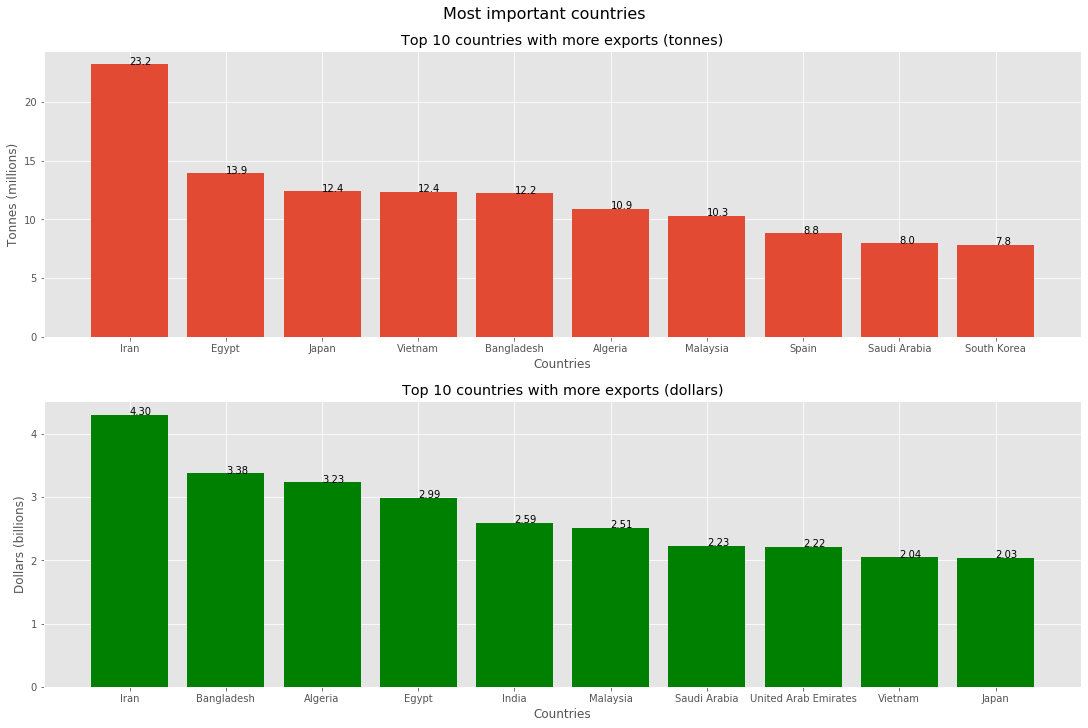

In [58]:
fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(15,10))

#Plot 1
axs[0].bar(top_tons_export.index, top_tons_export['export_total'])
axs[0].set_title('Top 10 countries with more exports (tonnes)')
axs[0].set_xlabel('Countries')
axs[0].set_ylabel('Tonnes (millions)')

for i in range(len(top_tons_export)):
    axs[0].text(x = top_tons_export.index[i], y = top_tons_export['export_total'][i], s = "{:.1f}".format((top_tons_export['export_total'][i])))
    
#Plot 2
axs[1].bar(top_usd_export.index, top_usd_export['export_total_usd'], color = 'green')
axs[1].set_title('Top 10 countries with more exports (dollars)')
axs[1].set_xlabel('Countries')
axs[1].set_ylabel('Dollars (billions)')

for i in range(len(top_tons_export)):
    axs[1].text(x = top_usd_export.index[i], y = top_usd_export['export_total_usd'][i], s = "{:.2f}".format((top_usd_export['export_total_usd'][i])))
    
fig.suptitle('Most important countries', fontsize=16)

plt.show()

In [33]:
#Total imported (considering dollars)
top_usd_import

,export_total,import_total,export_total_usd,import_total_usd
country,,,,
Paraguay,0.107062,4.307481,0.150100,602.728932
Argentina,0.007612,2.137111,0.022978,396.012398
United States,1.688463,0.007377,0.808318,28.941893
Bolivia,0.032131,0.001667,0.019279,3.970951
Chile,0.437753,0.000940,0.142813,0.828143
Mexico,2.565935,0.000065,0.440084,0.781056
Italy,0.703510,0.000442,0.115976,0.533616
Netherlands,2.484760,0.000081,0.453534,0.308301
Germany,0.022942,0.000089,0.019266,0.295132


In [34]:
#Total imported (considering tonnes)
top_tons_import

,export_total,import_total,export_total_usd,import_total_usd
country,,,,
Paraguay,0.107062,4.307481,0.150100,602.728932
Argentina,0.007612,2.137111,0.022978,396.012398
United States,1.688463,0.007377,0.808318,28.941893
Bolivia,0.032131,0.001667,0.019279,3.970951
Chile,0.437753,0.000940,0.142813,0.828143
Italy,0.703510,0.000442,0.115976,0.533616
Guatemala,0.382155,0.000320,0.062576,0.112903
Germany,0.022942,0.000089,0.019266,0.295132
Netherlands,2.484760,0.000081,0.453534,0.308301


# 5 - most importante UF consediring exportation by product

In almost all of the top 5, with the first in two categories.
The state of PR is present in all the top 5, but its total production considering all UFs is still below MT.

Variance in state of ESTADO, is the bigest showing that of all the products, this export is very concentrated on this platform

In [35]:
item_5 = ((date_grouped['type'] == 'Export'))

In [36]:
sampled_item_5 = date_grouped.apply(lambda x: x[item_5])

In [37]:
#Get the first bigest values in tonnes per each state
def sum_by_UF(df_product):
    return df_product.groupby('state').apply(lambda x: x['tons'].sum()/1000000).sort_values(ascending=False).nlargest(5)

In [38]:
state_values = sampled_item_5.groupby('product').apply(lambda x: sum_by_UF(x))
index = state_values.index

In [39]:
#Most Importante States
mis = pd.DataFrame(state_values.values, columns=['tons'], index=index)

In [40]:
def states_metrics(actual_product):
    actual_product_values = mis[mis.index.get_level_values(0) == str(actual_product)]['tons'].values
    actual_product_states = mis[mis.index.get_level_values(0) == str(actual_product)].index.get_level_values(1)
    return actual_product_states, actual_product_values

In [41]:
plot_state=[]
for i in range(len(mis.index.get_level_values(0).unique())):
    plot_state.append(states_metrics(mis.index.get_level_values(0).unique()[i]))

In [42]:
#statistics.variance(plot_state[0][1])

Text(0.5, 0.98, 'Most important states by product export')

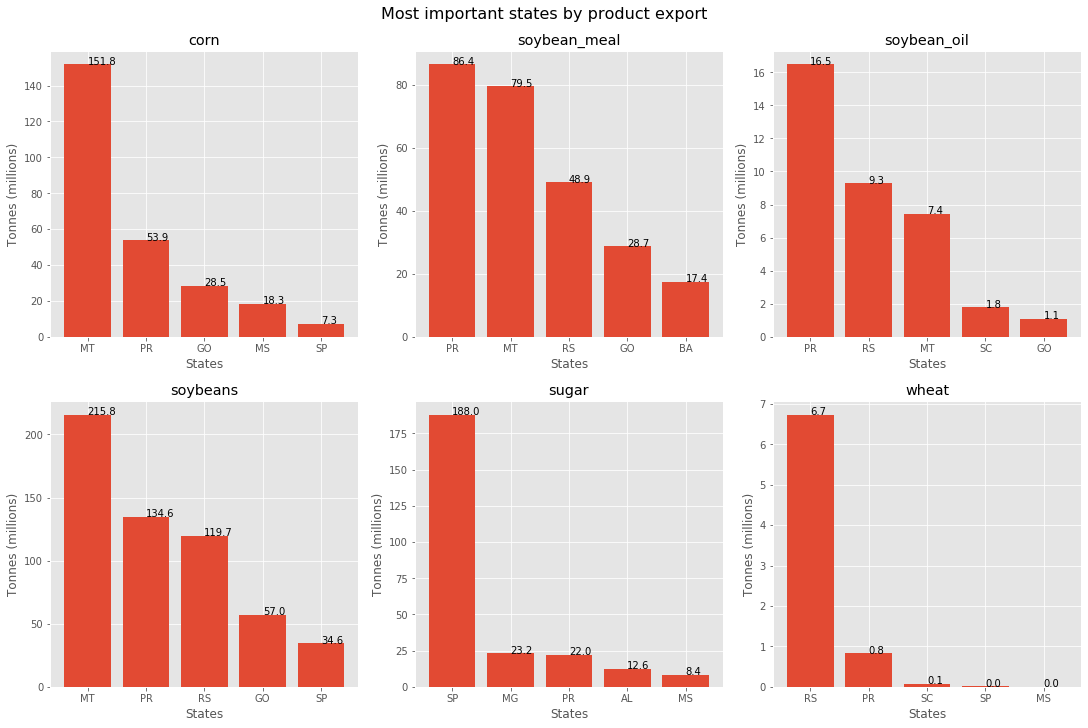

In [43]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        axs[i,j].bar(plot_state[count][0], plot_state[count][1])
        axs[i,j].set_title(mis.index.get_level_values(0).unique()[count])
        axs[i,j].set_xlabel('States')
        axs[i,j].set_ylabel('Tonnes (millions)')

        for k in range(len(plot_state[count][0])):
            axs[i,j].text(x = plot_state[count][0][k], y = plot_state[count][1][k], s = "{:.1f}".format((plot_state[count][1][k])))
        count+=1
        
fig.suptitle('Most important states by product export', fontsize=16)

#  6 - Predict

Por enquanto só com soja

In [44]:
historical_serie = pd.read_excel('covariates.xlsx')

In [45]:
historical_serie.head(5)

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1980,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250


In [46]:
#Anual exportation
item_6 = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == 'soybeans'))
exportations = date_grouped.apply(lambda x: x[item_6])
total_exportation = exportations.groupby(exportations.index.year).apply(lambda x: x['tons'].sum()/MILLION)

In [47]:
#Model for forecast
model = pd.DataFrame(total_exportation)
model.reset_index(inplace=True)
model.columns = ['year','total_exported']

In [48]:
historical_serie.head(5)

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1980,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250


In [49]:
def get_historical_values(row):
    if model['year'].any([row]):
        return row

In [50]:
#historical_serie.applymap(lambda x: get_historical_values(x))

In [51]:
#Necessário usar series estacionarias (fazer a diferença entre ontem e hj) invez do preço atual

In [52]:
model['year'].any()

True

In [53]:
total_exportation[total_exportation.index == 2000].index[0]

2000